<header style="padding: 4em 0 0em 0">
    <img src="http://brentyi.github.io/filestore/ai4all_logo.svg" style="width: 30em; height: auto; margin: 0;" />
    <h3 style="margin: 1em 0 0 0;">
        <strong>Computer Vision II</strong>
        <span style="color: #777">
        &nbsp;&blacksquare;&nbsp;
        Robotics, Summer 2020</span>
    </h3>
</header>

<hr style="border-top: 0.4em solid #eee;" />

In this notebook, we'll take a look at different ways of actually processing and manipulating images.
We'll implement three operations: **crop**, **resize**, and **rotate**.

This will be done in RGB, but do still keep other color representations in mind &mdash; they'll come in handy soon!

<hr style="border-top: 0.4em solid #eee;" />

Before we get started, let's import NumPy and load a test image:

In [18]:
import numpy as np
from cv_helpers import load_image, visualize_rgb

rgb_image = load_image("cv_assets/baboon.jpg")

## 1. Cropping

One of the most common operations we perform when working with images is rectangular **cropping**, or the action of removing unwanted outer areas of an image:

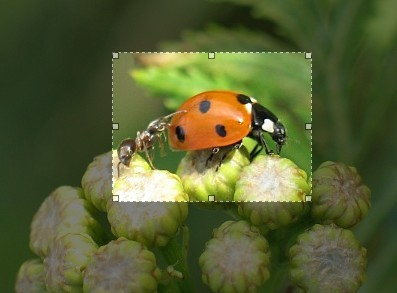

Take a look at this code we've written to crop out everything but the eyes of our baboon from above:

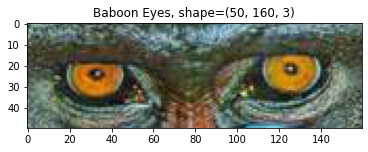

In [19]:
visualize_rgb("Baboon Eyes", rgb_image[10:60, 70:230, :])

Notice that this can be equivalently written as:

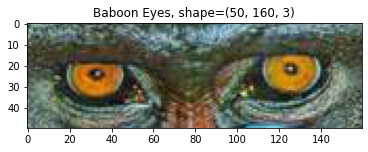

In [20]:
visualize_rgb("Baboon Eyes", rgb_image[10:60, 70:-70, :])

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Cropping</div>

Take a look at each cropping operation from above: what do each of the numbers represent?

Try cropping the image for yourself in the cell below; see if you can pull out a 100x100 square from the bottom left of `rgb_image`.

> Your response here!


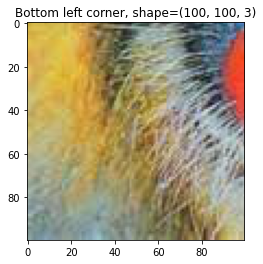

In [21]:
# ~~START DELETE~~
visualize_rgb("Bottom left corner", rgb_image[-100:, :100, :])
# ~~END DELETE~~

### 2. Resizing

Finally, let's wrap up with another commonly used operation: image resizing!

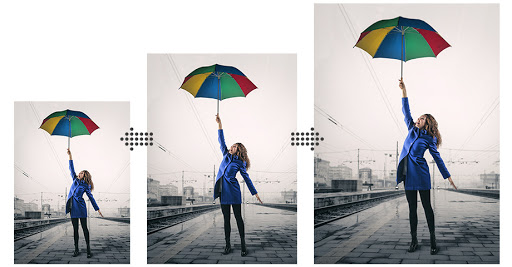

At a high level, image resizing should go something like this:

1. We create an (initially empty) output array of the desired size, `output_image`
2. We iterate over each pixel position `(i,j)` in the output image
    - For each output pixel, we compute a corresponding input pixel `(input_i, input_j)`
    - We assign `output_image[i, j, :]` to `input_image[input_i, input_j, :]`
3. We return the resized output image

For computing `input_i` and `input_j`, we'll use the "nearest neighbor" method.
We want these to increase proportionally with `i` and `j` respectively:

- `input_i` can be computed as `int(i * row_scale_factor)`
- `input_j` can be computed as `int(j * col_scale_factor)`

...where `int()` is a Python operation takes a number and rounds it down to the nearest integer, and `row_scale_factor` and `col_scale_factor` are constants computed from the image input/output sizes.

Try to figure out what `row_scale_factor` and `col_scale_factor` should be, and implement this algorithm in the skeleton below!

In [22]:
def resize_image(input_image, output_rows, output_cols):
    """Resize an image using the nearest neighbor method.
    
    Args:
        input_image (np.ndarray): RGB image stored as an array, with shape
            `(input_rows, input_cols, 3)`.
        output_rows (int): Number of rows in our desired output image.
        output_cols (int): Number of columns in our desired output image.

    Returns:
        (np.ndarray): Resized image, with shape `(output_rows, output_cols, 3)`.
    """
    input_rows, input_cols, channels = input_image.shape
    assert channels == 3

    # 1. Create the resized output image
    output_image = np.zeros(shape=(output_rows, output_cols, 3))

    # 2. Populate the `output_image` array using values from `input_image`
    #    > This should require two nested for loops!
    # ~~START DELETE~~
    for i in range(output_rows):
        for j in range(output_cols):
            input_i = int(i / output_rows * input_rows)
            input_j = int(j / output_cols * input_cols)
            output_image[i, j, :] = input_image[input_i, input_j, :]
    # ~~END DELETE~~

    # 3. Return the output image
    return output_image

<div style="color: #a00; font-weight: 800; padding: 1em 0; border-top: 0.4em solid #eee;">Checkoff: Resizing</div>

Run the cells below to test out your image resizing algorithm!

When you downsize the baboon to 16x16, you should expect an output that looks something like this:

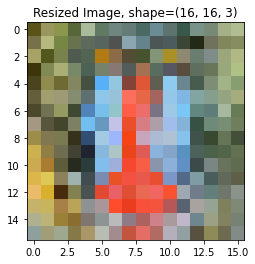

Question: in the resize algorithm we describe above, the output is populated by iterating over the indices of the output image. Could we implement image resizing by iterating over the indices of the input image instead? How do the two approaches compare?

> *Your response here!*

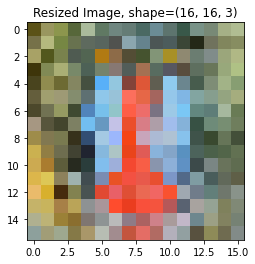

In [23]:
# Visualize downsizing an image
visualize_rgb("Resized Image", resize_image(rgb_image, 16, 16))

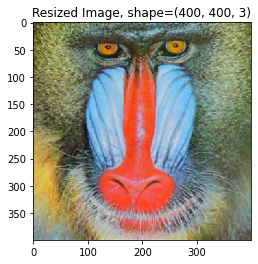

In [24]:
# Visualizing upsizing an image: this should look almost identical to the input image
visualize_rgb("Resized Image", resize_image(rgb_image, 400, 400))

### 3. (Bonus) Image Rotation

For those of you who've gotten this far &mdash; congratulations, you're done!

If you have extra time, one more operation that  you can try implementing is **image rotation**. This is part of a real interview question that we've encountered for actual computer vision jobs (notably at Facebook), requires reasoning about sines and cosines, and we expect it to be difficult.

For an input angle of $\pi/4$ (45 degrees), the expected output is:

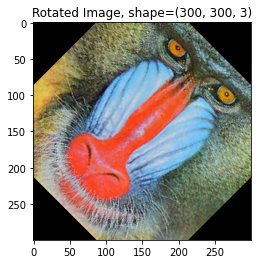

In [25]:
def rotate_image(input_image, theta):
    """Rotate an image by some angle theta.
    
    Args:
        input_image (np.ndarray): RGB image stored as an array, with shape
            `(input_rows, input_cols, 3)`.
        theta (float): Angle to rotate our image by, in radians.

    Returns:
        (np.ndarray): Rotated image, with the same shape as the input.
    """
    input_rows, input_cols, channels = input_image.shape
    assert channels == 3

    # 1. Create an output image with the same shape as the input
    output_image = np.zeros_like(input_image)

    # 2. Populate the `output_image` array using values from `input_image`
    #    > This should require two nested for loops!
    #    > We can ignore any values of (input_i, input_j) that fall outside of
    #      the input image
    # ~~START DELETE~~
    R = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    center = np.array([[input_rows // 2, input_cols // 2]]).T
    for i in range(input_rows):
        for j in range(input_cols):
            input_i, input_j = (
                (R @ (np.array([[i, j]]).T - center) + center)
                .squeeze()
                .astype(np.int64)
            )
            if 0 <= input_i < input_rows and 0 <= input_j < input_cols:
                output_image[i, j, :] = input_image[input_i, input_j, :]
    # ~~END DELETE~~

    # 3. Return the output image
    return output_image

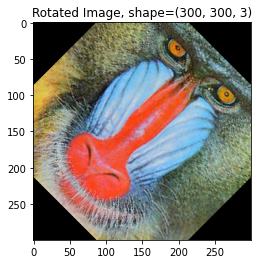

In [14]:
visualize_rgb("Rotated Image", rotate_image(rgb_image, np.pi / 4.0))